In [ ]:
import torch
torch.cuda.is_available() # if True, GPU is available.

True

Currently, all dataset is under `data`.
Split the dataset.

In [4]:
import os
import random
import shutil

# Define paths
data_dir = 'data'

train_dir = 'split/train'
val_dir = 'split/val'
test_dir = 'split/test'

# Define split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    # Create class directories in train, val, and test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    # Get list of files in the class directory
    files = os.listdir(class_dir)
    random.shuffle(files)  # Shuffle the files
    
    # Calculate split indices
    train_split = int(len(files) * train_ratio)
    val_split = train_split + int(len(files) * val_ratio)
    
    # Split files into train, val, and test
    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]
    
    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(train_dir, class_name, file))
    
    for file in val_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(val_dir, class_name, file))
    
    for file in test_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(test_dir, class_name, file))

print("Data split completed!")

Data split completed!


In [11]:
from resnet_classifier import *
from pathlib import Path
from datetime import datetime

# Configuration
DATA_ROOT = Path("split")  # Update this path
train_path = DATA_ROOT/"train"
val_path = DATA_ROOT/"val"
test_path = DATA_ROOT/"test"

model_config = {
    "num_classes": 3,
    "resnet_version": 101,
    "train_path": train_path,
    "val_path": val_path,
    "test_path": test_path,
    "optimizer": "adam",
    "lr": 1e-4,
    "batch_size": 64,
    "transfer": True,
    "tune_fc_only": True
}

# Initialize model
model = ResNetClassifier(**model_config)


# Create a timestamp and get architecture name
now = datetime.now().strftime("%Y%m%d_%H%M%S")
arch = f"resnet{model_config['resnet_version']}"

# Training setup
checkpoint_cb = ModelCheckpoint(
    # Save checkpoints inside "checkpoints/{now}" folder.
    dirpath=f"checkpoints/{now}",
    # The filename will include the model architecture and epoch number.
    filename=f"{arch}_epoch{{epoch}}.pth",  # Note the double curly braces around epoch are needed for formatting.
    monitor="val_acc",
    mode="max",
    save_top_k=1,
)

early_stop_cb = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max"
)

trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_cb, early_stop_cb],
    accelerator="auto",
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=10
)

# Train the model
trainer.fit(model)

# Test the model (if test set available)
if test_path.exists():
    trainer.test(ckpt_path="best")


# Construct dynamic filename for the final model
final_filename = f"{arch}_final_{now}.pth"

# Save final model weights with the dynamic filename
torch.save(model.resnet_model.state_dict(), final_filename)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss_fn      | CrossEntropyLoss   | 0      | train
1 | acc          | MulticlassAccuracy | 0      | train
2 | resnet_model | ResNet             | 42.5 M | train
------------------------------------------------------------
6.1 K     Trainable params
42.5 M    Non-trainable params
42.5 M    Total params
170.025   Total estimated model params size (MB)
289       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 9/9 [00:45<00:00,  0.20it/s, v_num=2, train_loss=0.805, train_acc=0.600, val_loss=0.745, val_acc=0.859]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 9/9 [00:46<00:00,  0.19it/s, v_num=2, train_loss=0.805, train_acc=0.600, val_loss=0.745, val_acc=0.859]

Restoring states from the checkpoint path at /home/huijo_hexafarms_com/test/checkpoints/20250220_135217/resnet101_epochepoch=19.pth.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded model weights from the checkpoint at /home/huijo_hexafarms_com/test/checkpoints/20250220_135217/resnet101_epochepoch=19.pth.ckpt


Testing DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7735849022865295     │
│         test_loss         │    0.7576866745948792     │
└───────────────────────────┴───────────────────────────┘

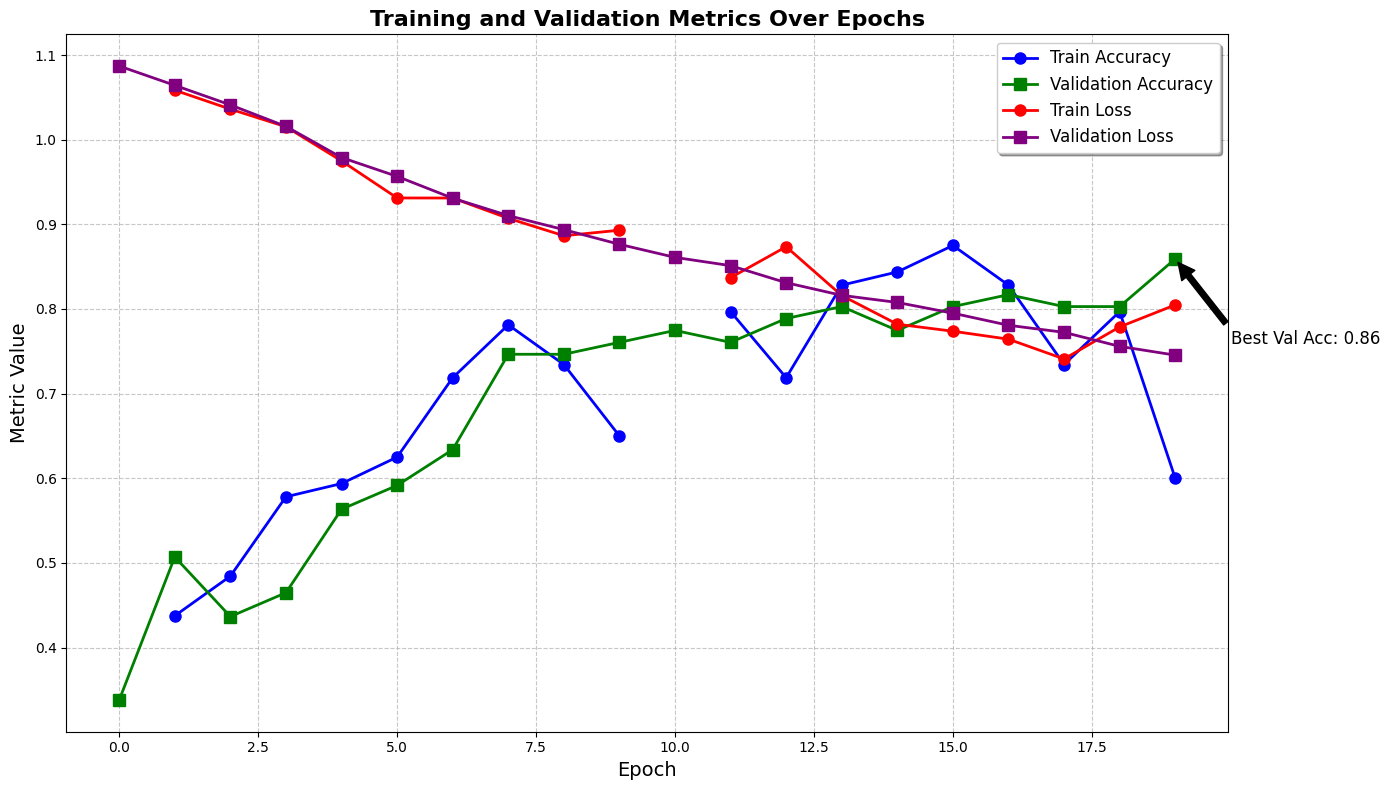

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_metrics(csv_directory, highest_version=None):
    # Find the highest version folder
    version_folders = [f for f in os.listdir(csv_directory) if f.startswith("version_")]
    if not version_folders:
        raise FileNotFoundError("No version folders found in the directory.")

    # Determine the highest version number
    if highest_version is None:
        highest_version = max(version_folders, key=lambda v: int(v.split('_')[1]))
    csv_path = os.path.join(csv_directory, str(highest_version), 'metrics.csv')

    # Load the CSV data into a DataFrame
    df = pd.read_csv(csv_path)

    # Replace empty strings with NaN and convert to appropriate data types for plotting
    df = df.replace('', float('nan'))

    # Group by epoch and calculate mean values for each epoch
    df_epoch = df.groupby('epoch').mean().reset_index()

    # Plot the metrics over epochs
    plt.figure(figsize=(14, 8))

    # Plot training accuracy
    plt.plot(df_epoch['epoch'], df_epoch['train_acc'], label='Train Accuracy', marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
    
    # Plot validation accuracy
    plt.plot(df_epoch['epoch'], df_epoch['val_acc'], label='Validation Accuracy', marker='s', color='green', linestyle='-', linewidth=2, markersize=8)

    # Plot training loss
    plt.plot(df_epoch['epoch'], df_epoch['train_loss'], label='Train Loss', marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
    
    # Plot validation loss
    plt.plot(df_epoch['epoch'], df_epoch['val_loss'], label='Validation Loss', marker='s', color='purple', linestyle='-', linewidth=2, markersize=8)

    # Add a legend
    plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, facecolor='white')

    # Add labels and title
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Metric Value', fontsize=14)
    plt.title('Training and Validation Metrics Over Epochs', fontsize=16, fontweight='bold')

    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add annotations for the best validation accuracy
    best_val_acc_epoch = df_epoch['val_acc'].idxmax()
    best_val_acc = df_epoch.loc[best_val_acc_epoch, 'val_acc']
    plt.annotate(f'Best Val Acc: {best_val_acc:.2f}', 
                 xy=(best_val_acc_epoch, best_val_acc), 
                 xytext=(best_val_acc_epoch + 1, best_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics('lightning_logs')